The goal is to model the success of subscribing a long-term deposit using attributes that
 were known before the telemarketing call was executed. 

Data Cleaning

In [89]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [90]:
# reading the data into a dataframe and making a copy
df_pd = pd.read_csv("Dataset/bank-additional/bank-additional/bank-additional-full.csv", sep=";")
df = df_pd.copy()

In [91]:
df.shape

(41188, 21)

In [92]:
# brief overview of the dataset
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [93]:
# no null values 
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [94]:
# Check for duplicates
duplicates = df.duplicated()
print(duplicates.sum())  

12


In [95]:
# Remove duplicates
df = df.drop_duplicates()
df.shape # reduced to 41176 from 41188

(41176, 21)

In [96]:
# The duration is not known before a call is performed, therefore it is not used for model training
df.drop(columns = ["duration"], inplace = True)

In [97]:
# check unique values of categorical columns to identify structural errors
for x in df.select_dtypes("object").columns:
    print(x)
    print(df[x].unique())
    print(" ")

job
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
 
marital
['married' 'single' 'divorced' 'unknown']
 
education
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
 
default
['no' 'unknown' 'yes']
 
housing
['no' 'yes' 'unknown']
 
loan
['no' 'yes' 'unknown']
 
contact
['telephone' 'cellular']
 
month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
 
day_of_week
['mon' 'tue' 'wed' 'thu' 'fri']
 
poutcome
['nonexistent' 'failure' 'success']
 
y
['no' 'yes']
 


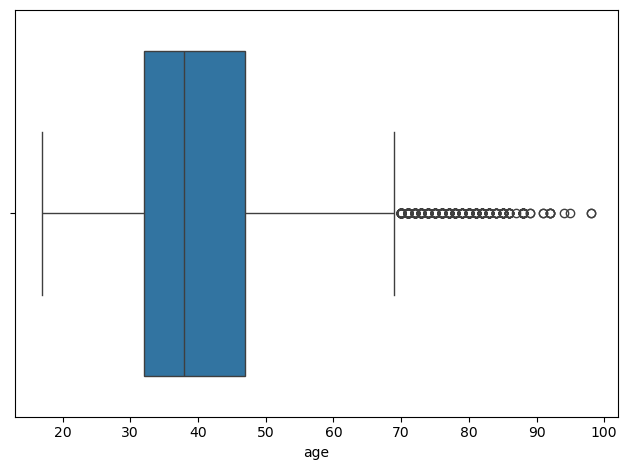

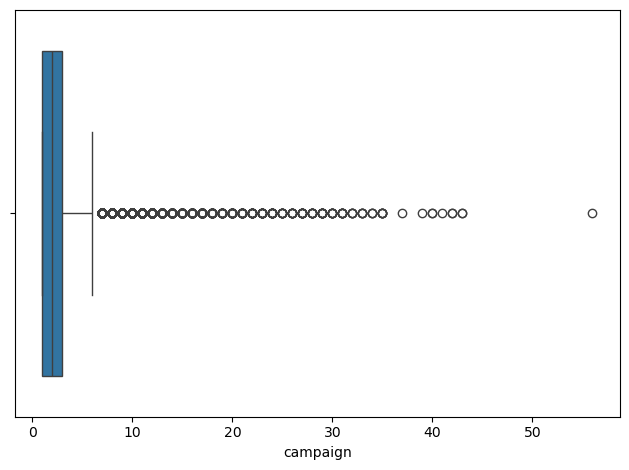

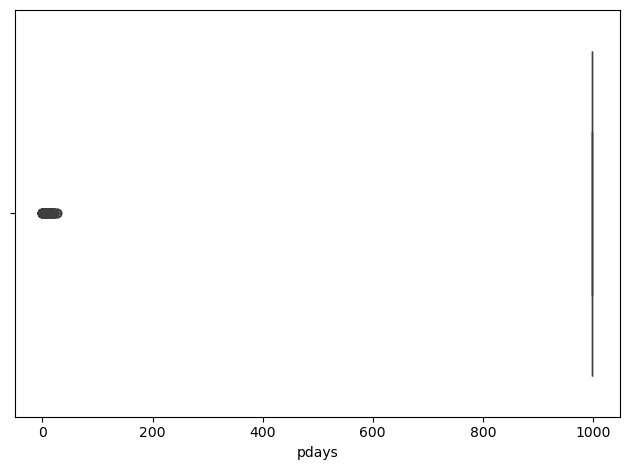

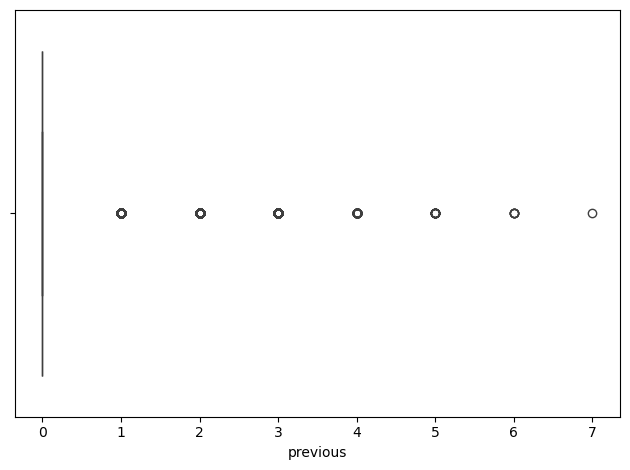

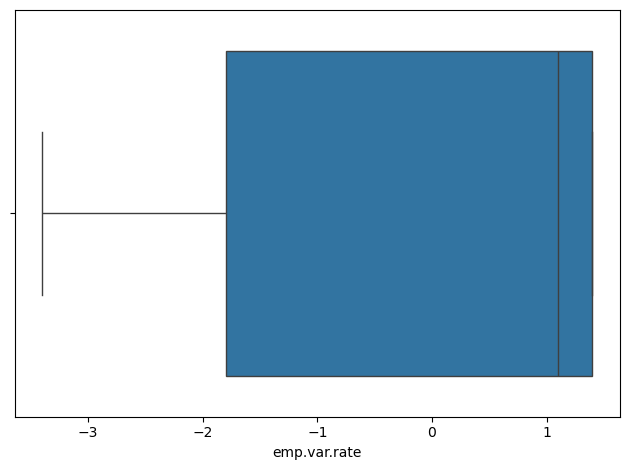

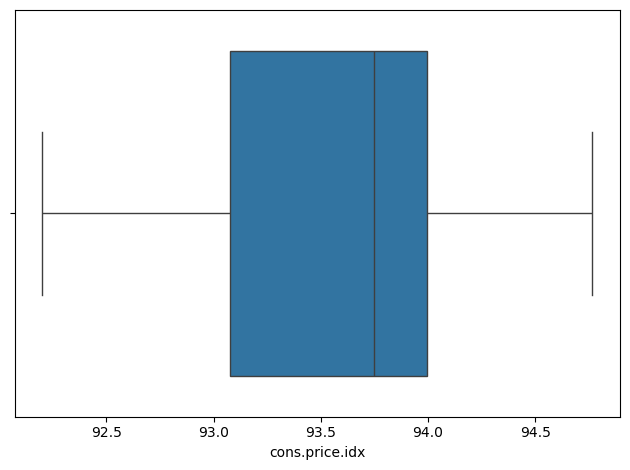

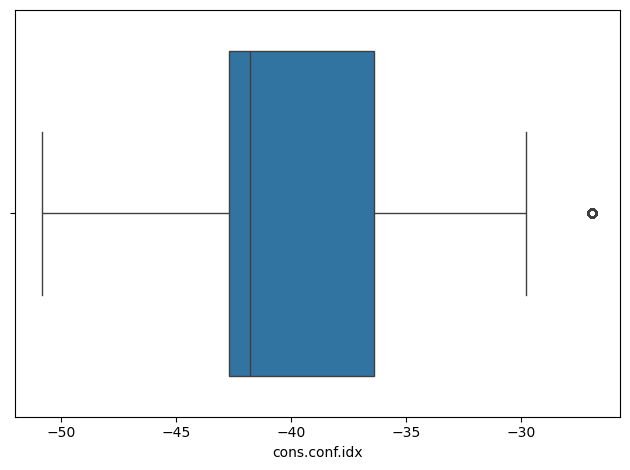

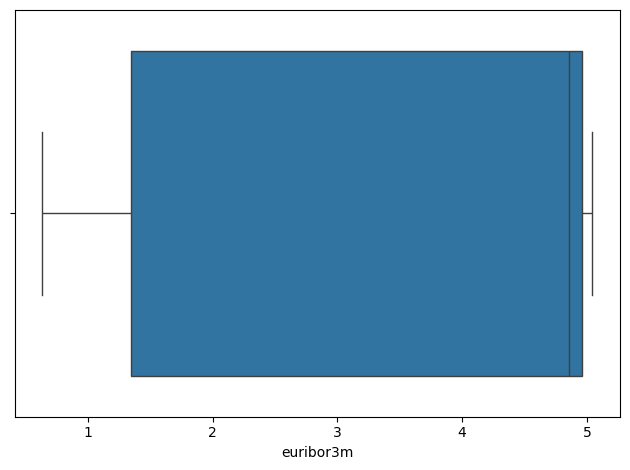

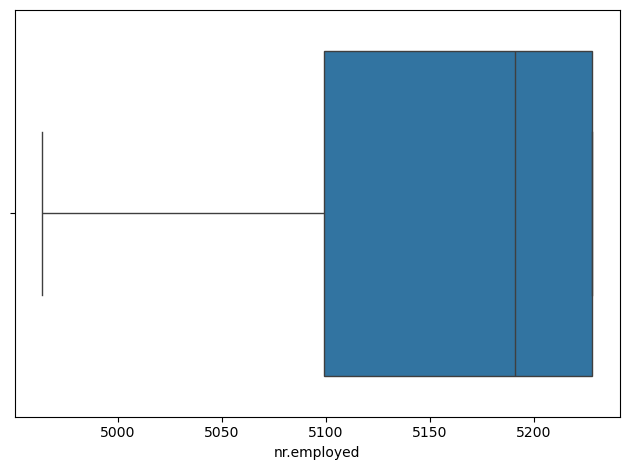

In [98]:
# check for outliers in numerical columns by plotting boxplots 
for col in df.select_dtypes("number").columns:
    sns.boxplot(x=df[col])
    plt.tight_layout()
    plt.show()

In [99]:
# outliers in age are not handled, they are valid outliers
# decide what to do for pdays, previous, campaign outliers
# cons.conf.idx as well

In [100]:
# Function to calculate lower bound and upper bound
def get_outliers(series):
    Q1 = series.quantile(0.25)  # First quartile (25th percentile)
    Q3 = series.quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Count outliers
    outliers = ((series < lower_bound) | (series > upper_bound)).sum()
    # Percentage of outliers
    return outliers

In [101]:
# campaign indicates the number of contacts performed during this campaign for each client
outliers = get_outliers(df.campaign)

# find number of outliers as a percentage
(outliers / df.shape[0]) * 100


5.8432096366815625

In [102]:
# Use quantile based flooring and capping to impute the outliers

# Computing 10th and 90th percentiles 
tenth_percentile = np.percentile(df.campaign, 10) 
ninetieth_percentile = np.percentile(df.campaign, 90) 

# Apply flooring and capping
df.campaign = np.clip(df.campaign, tenth_percentile, ninetieth_percentile)

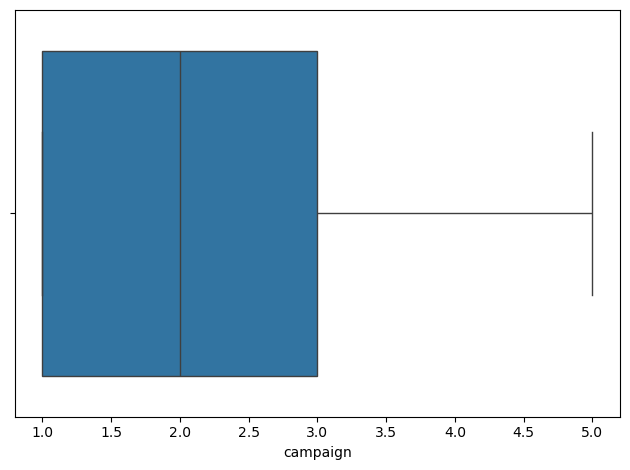

In [103]:
# outliers handled
sns.boxplot(x=df["campaign"])
plt.tight_layout()
plt.show()

In [104]:
# pdays is the number of days that passed by after the client was last contacted from a previous campaign
df[df['pdays'] == 999]['pdays'].shape[0]*100/df.shape[0] # around 96% clients were not contacted

96.32067223625413

In [105]:
# Random forest model will handle this
outliers = get_outliers(df['pdays'])
outliers/df.shape[0]*100

3.6793277637458717

In [106]:
# previous is the number of contacts performed before this campaign and for this client 
df[df['previous'] == 0]['previous'].shape[0]*100/df.shape[0] # around 86% clients had 0 contacts

86.33912959005245

In [107]:
# Random forest model will handle this
outliers = get_outliers(df['previous'])
outliers/df.shape[0]*100

13.660870409947542

In [108]:
# cons.conf.idx: consumer confidence index - monthly indicator
outliers = get_outliers(df['cons.conf.idx'])
outliers/df.shape[0]*100   # only 1% outliers, will be handled by the random forest model

1.0831552360598407

In [109]:
# Visualize the "unknown" value percentage of each column
unknownDF = pd.DataFrame({"Column": pd.Series(dtype="str"), "Unknown_Percentage": pd.Series(dtype="float")})
for x in df.columns:
    numberUnknown = df[x][df[x] == 'unknown'].shape[0]
    numberUnknown += df[x][df[x] == 'nonexistent'].shape[0]
    unknownProportion = numberUnknown/df.shape[0]
    # only non zero percentages are displayed
    if unknownProportion != 0:
        new_row = pd.DataFrame({"Column":[x], "Unknown_Percentage":[unknownProportion*100]})
        unknownDF = pd.concat([unknownDF, new_row], ignore_index=True)
unknownDF

,Column,Unknown_Percentage
0,job,0.801438
1,marital,0.194288
2,education,4.201477
3,default,20.876239
4,housing,2.404313
5,loan,2.404313
6,poutcome,86.339130


In [110]:
# remove "unknown" rows from job column
df = df[df["job"] != "unknown"]

In [111]:
# remove "unknown" rows from marital column
df = df[df["marital"] != "unknown"]

In [112]:
# remove "unknown" rows from education column
df = df[df["education"] != "unknown"]

In [113]:
# remove "unknown" rows from housing column
df = df[df["housing"] != "unknown"]

In [114]:
# remove "unknown" rows from loan column
df = df[df["loan"] != "unknown"]

In [115]:
# drop poutcome column
df.drop(columns = ['poutcome'], inplace = True)

In [116]:
# impute "unknown" in default column
print(df.default.value_counts())

# Replace "unknown" with NaN
df['default'] = df['default'].replace("unknown", np.nan)

# Impute missing values with the mode (most frequent value)
df['default'] = df['default'].fillna(df['default'].mode()[0])


default
no         30475
unknown     7756
yes            3
Name: count, dtype: int64


In [117]:
print(df.default.value_counts())

default
no     38231
yes        3
Name: count, dtype: int64


In [118]:
df.shape

(38234, 19)

In [119]:
df.y.value_counts()

y
no     33977
yes     4257
Name: count, dtype: int64

In [120]:
# class imbalance
class_counts = df['y'].value_counts()

# Display the counts and the ratio
print("Class counts:")
print(class_counts)
print(f"\nClass imbalance ratio: {class_counts.iloc[0]/df.shape[0]:.3f}: {class_counts.iloc[1]/df.shape[0]:.3f}")


Class counts:
y
no     33977
yes     4257
Name: count, dtype: int64

Class imbalance ratio: 0.889: 0.111


In [121]:
# one hot encoding
df = pd.get_dummies(df, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month','day_of_week'], drop_first=True)

In [122]:
df.shape

(38234, 45)

In [123]:
# Encode "yes" as 1 and "no" as 0
df['y'] = df['y'].map({'yes': 1, 'no': 0})

In [124]:
y = df.y
X = df.drop(columns = ['y'])

In [125]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# Evaluate the best model
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")
print("Confusion Matrix:")
print(conf_matrix)

Training Accuracy: 0.9949557224526399
Testing Accuracy: 0.8898090837764798
Confusion Matrix:
[[9872  293]
 [ 971  335]]


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'max_depth': 22, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 35}
Training Accuracy: 0.9436535515450435
Testing Accuracy: 0.8783018045506059
Confusion Matrix:
[[9433  732]
 [ 664  642]]


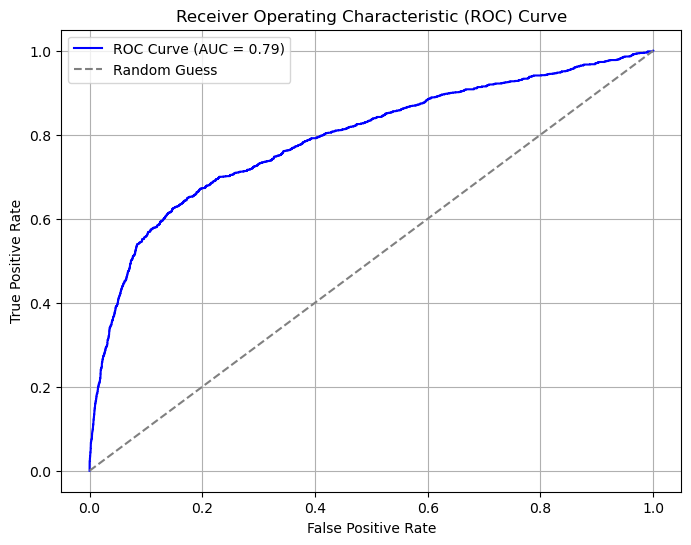

In [136]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [29, 35, 39],
    'max_depth': [15, 22, 35],
    'min_samples_split': [4],
    'min_samples_leaf': [2],
    'max_features': ['log2', 'sqrt']
}

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

print(f"Best Parameters: {best_params}")
print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")
print("Confusion Matrix:")
print(conf_matrix)

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Predicted probabilities for the positive class
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Second column corresponds to class 1 probabilities
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()

